In [8]:
from typing import Annotated
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_experimental.tools import PythonREPLTool

tavily_tool = TavilySearchResults(max_results=5)  # 웹서치
python_repl_tool = PythonREPLTool()  # 차트 생성

yfinance : 주식 정보를 가져오는 도구

In [ ]:
import yfinance as yf
from datetime import datetime, timedelta
import pandas as pd

ticker = yf.Ticker("NVDA")  # NVDA
historical_prices = ticker.history(
    period="5d", interval="1d"
)  # 1일 주가 정보를 5일치를 가져오겠다.

last_5_days_close = historical_prices["Close"].tail(5)
last_5_days_close_dict = {
    date.strftime("%Y-%m-%d"): price for date, price in last_5_days_close.items()
}
# 연간 및 분기별 재무제표 데이터 가져오기
last_5_days_close_dict

{'2024-11-08': 147.6300048828125,
 '2024-11-11': 145.25999450683594,
 '2024-11-12': 148.2899932861328,
 '2024-11-13': 146.27000427246094,
 '2024-11-14': 146.75999450683594}

재무 정보 데이터셋화 도구

In [ ]:
from langchain.tools import BaseTool, StructuredTool, tool
import yfinance as yf
from datetime import datetime, timedelta
import pandas as pd


# 재무 분석 툴 설정
@tool
def stock_analysis(ticker: str) -> str:
    """
    주어진 주식 티커에 대한 업데이트된 종합적인 재무 분석을 수행합니다.
    최신 주가 정보, 재무 지표, 성장률, 밸류에이션 및 주요 비율을 제공합니다.
    가장 최근 영업일 기준의 데이터를 사용합니다.

    :param ticker: 분석할 주식의 티커 심볼
    :return: 재무 분석 결과를 포함한 문자열
    """

    def format_number(number):
        if number is None or pd.isna(number):
            return "N/A"
        return f"{number:,.0f}"

    def format_financial_summary(financials):
        summary = {}
        for date, data in financials.items():
            date_str = date.strftime("%Y-%m-%d")
            summary[date_str] = {
                "총수익": format_number(data.get("TotalRevenue")),
                "영업이익": format_number(data.get("OperatingIncome")),
                "순이익": format_number(data.get("NetIncome")),
                "EBITDA": format_number(data.get("EBITDA")),
                "EPS(희석)": (
                    f"${data.get('DilutedEPS'):.2f}"
                    if pd.notna(data.get("DilutedEPS"))
                    else "N/A"
                ),
            }
        return summary

    ticker = yf.Ticker(ticker)
    historical_prices = ticker.history(period="5d", interval="1d")

    last_5_days_close = historical_prices["Close"].tail(5)
    last_5_days_close_dict = {
        date.strftime("%Y-%m-%d"): price for date, price in last_5_days_close.items()
    }
    # 연간 및 분기별 재무제표 데이터 가져오기
    annual_financials = ticker.get_financials()
    quarterly_financials = ticker.get_financials(freq="quarterly")

    return str(
        {
            "최근 5일간 종가": last_5_days_close_dict,
            "연간 재무제표 요약": format_financial_summary(annual_financials),
            "분기별 재무제표 요약": format_financial_summary(quarterly_financials),
        }
    )

Supervisor 정의

In [ ]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
from typing import Literal

members = ["Researcher", "Stock_Analyzer", "Chart_Generator"]
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = ["FINISH"] + members


class routeResponse(BaseModel):
    next: Literal["FINISH", "Researcher", "Stock_Analyzer", "Chart_Generator"]


prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))


llm = ChatOpenAI(model="gpt-4o-mini")


def supervisor_agent(state):
    supervisor_chain = prompt | llm.with_structured_output(routeResponse)
    return supervisor_chain.invoke(state)

하위 에이전트 실행 함수

In [5]:
from langchain_core.messages import HumanMessage

def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["messages"][-1].content, name=name)]}

In [9]:
import functools
import operator
from typing import Sequence, TypedDict , Annotated

from langchain_core.messages import BaseMessage

from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import create_react_agent

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add] # 메시지 저장
    next: str # 다음 실행 agent 저장

research_system_prompt = """You are a helpful research analyst who is specialized in 
gathering valuable info for given stock."""
research_agent = create_react_agent(llm, tools=[tavily_tool], state_modifier=research_system_prompt)
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION. PROCEED WITH CAUTION
stock_system_prompt="""You are a helpful Stock and financial analyst. Never hallucinate the given metrics."""
stock_agent = create_react_agent(llm, tools=[stock_analysis], state_modifier=stock_system_prompt)
stock_node = functools.partial(agent_node, agent=stock_agent, name="Stock_Analyzer")

# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION. PROCEED WITH CAUTION
chart_system_prompt="""You are a helpful Stock Chart Generator. 
Only make accurate charts for given query. Chart design and accuracy should be state of the art.
Never make any other mention."""
chart_agent = create_react_agent(llm, tools=[python_repl_tool], state_modifier=chart_system_prompt)
chart_node = functools.partial(agent_node, agent=chart_agent, name="Chart_Generator")

workflow = StateGraph(AgentState)
workflow.add_node("Researcher", research_node)
workflow.add_node("Stock_Analyzer", stock_node)
workflow.add_node("Chart_Generator", chart_node)
workflow.add_node("supervisor", supervisor_agent)

In [12]:
for member in members:
    # We want our workers to ALWAYS "report back" to the supervisor when done
    workflow.add_edge(member, "supervisor")
# The supervisor populates the "next" field in the graph state
# which routes to a node or finishes
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges(
    "supervisor", 
    lambda x: x["next"], 
    conditional_map)
# Finally, add entrypoint
workflow.add_edge(START, "supervisor")

graph = workflow.compile()

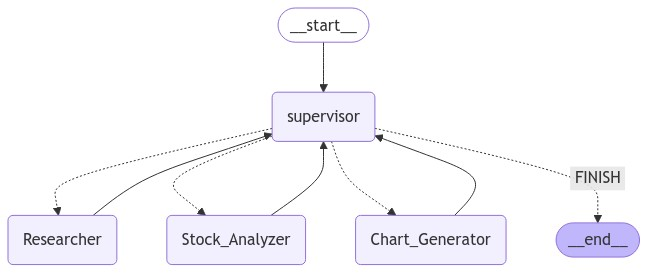

In [16]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
for s in graph.stream({"messages": [HumanMessage(content="애플 주식은 상태는 어때?")]}):
    if "__end__" not in s:
        print(s)
        print("----")